![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)







### Copyright notice

> <p><small><small>Copyright 2025 DeepMind Technologies Limited.</small></p>
> <p><small><small>Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0">http://www.apache.org/licenses/LICENSE-2.0</a>.</small></small></p>
> <p><small><small>Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.</small></small></p>

# Locomotion in The Playground! <a href="https://colab.research.google.com/github/google-deepmind/mujoco_playground/blob/main/learning/notebooks/locomotion.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a>

In this notebook, we'll walk through a few locomotion environments available in MuJoCo Playground.

**A Colab runtime with GPU acceleration is required.** If you're using a CPU-only runtime, you can switch using the menu "Runtime > Change runtime type".


In [ ]:
#@title Install pre-requisites
# !pip install mujoco
# !pip install mujoco_mjx
# !pip install brax

In [ ]:
# @title Check if MuJoCo installation was successful

import distutils.util
import os
import subprocess

if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.'
  )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco

  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".'
  )

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

os.environ["JAX_DEFAULT_MATMUL_PRECISION"] = "highest"

In [2]:
# @title Import packages for plotting and creating graphics
import json
import itertools
import time
from typing import Callable, List, NamedTuple, Optional, Union
import numpy as np

# Graphics and plotting.
print("Installing mediapy:")
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:


In [3]:
# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
import functools
import os
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import networks as sac_networks
from brax.training.agents.sac import train as sac
from etils import epath
from flax import struct
from flax.training import orbax_utils
from IPython.display import HTML, clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import numpy as np
from orbax import checkpoint as ocp

In [ ]:
#@title Install MuJoCo Playground
# !pip install playground

In [4]:
#@title Import The Playground

from mujoco_playground._src import wrapper
from mujoco_playground._src import registry

# Locomotion

MuJoCo Playground contains a host of quadrupedal and bipedal environments (all listed below after running the command).

In [5]:
registry.locomotion.ALL_ENVS

('BarkourJoystick',
 'BerkeleyHumanoidJoystickFlatTerrain',
 'BerkeleyHumanoidJoystickRoughTerrain',
 'G1JoystickFlatTerrain',
 'G1JoystickRoughTerrain',
 'Go1JoystickFlatTerrain',
 'Go1JoystickRoughTerrain',
 'Go1Getup',
 'Go1Handstand',
 'Go1Footstand',
 'H1InplaceGaitTracking',
 'H1JoystickGaitTracking',
 'Op3Joystick',
 'SpotFlatTerrainJoystick',
 'SpotGetup',
 'SpotJoystickGaitTracking',
 'T1JoystickFlatTerrain',
 'T1JoystickRoughTerrain',
 'Go2JoystickFlatTerrain')

# Quadrupedal

Let's jump right into quadrupedal locomotion! While we have environments available for the Google Barkour and Boston Dynamics Spot robots, the Unitree Go1 environment contains the most trainable policies that were transferred onto the real robot. We'll go right ahead and show a few policies using the Unitree Go1!

First, let's train a joystick policy, which tracks linear and yaw velocity commands.

In [7]:
env_name = 'Go2JoystickFlatTerrain'
env = registry.load(env_name)
env_cfg = registry.get_default_config(env_name)

In [8]:
env_cfg

Kd: 0.5
Kp: 35.0
action_repeat: 1
action_scale: 0.5
command_config:
  a:
  - 1.5
  - 0.8
  - 1.2
  b:
  - 0.9
  - 0.25
  - 0.5
ctrl_dt: 0.02
episode_length: 1000
history_len: 1
noise_config:
  level: 1.0
  scales:
    gravity: 0.05
    gyro: 0.2
    joint_pos: 0.03
    joint_vel: 1.5
    linvel: 0.1
pert_config:
  enable: false
  kick_durations:
  - 0.05
  - 0.2
  kick_wait_times:
  - 1.0
  - 3.0
  velocity_kick:
  - 0.0
  - 3.0
reward_config:
  max_foot_height: 0.1
  scales:
    action_rate: -0.01
    ang_vel_xy: -0.05
    dof_pos_limits: -1.0
    energy: -0.001
    feet_air_time: 0.1
    feet_clearance: -2.0
    feet_height: -0.2
    feet_slip: -0.1
    lin_vel_z: -0.5
    orientation: -5.0
    pose: 0.5
    stand_still: -1.0
    termination: -1.0
    torques: -0.0002
    tracking_ang_vel: 0.5
    tracking_lin_vel: 1.0
  tracking_sigma: 0.25
sim_dt: 0.004
soft_joint_pos_limit_factor: 0.95

## Joystick

Let's train the joystick policy and visualize rollouts:

In [9]:
from mujoco_playground.config import locomotion_params
ppo_params = locomotion_params.brax_ppo_config(env_name)
ppo_params

action_repeat: 1
batch_size: 256
discounting: 0.97
entropy_cost: 0.01
episode_length: 1000
learning_rate: 0.0003
max_grad_norm: 1.0
network_factory:
  policy_hidden_layer_sizes: &id001 !!python/tuple
  - 512
  - 256
  - 128
  policy_obs_key: state
  value_hidden_layer_sizes: *id001
  value_obs_key: privileged_state
normalize_observations: true
num_envs: 8192
num_evals: 10
num_minibatches: 32
num_resets_per_eval: 1
num_timesteps: 200000000
num_updates_per_batch: 4
reward_scaling: 1.0
unroll_length: 20

Domain randomization was used to make the policy robust to sim-to-real transfer. Certain environments in the Playground have domain randomization functions implemented. They're available in the registry and can be passed directly to brax RL algorithms. The [domain randomization](https://github.com/google-deepmind/mujoco_playground/blob/main/mujoco_playground/_src/locomotion/go1/randomize.py) function randomizes over friction, armature, center of mass of the torso, and link masses, amongst other simulation parameters.

In [7]:
registry.get_domain_randomizer(env_name)

<function mujoco_playground._src.locomotion.go2.randomize.domain_randomize(model: mujoco.mjx._src.types.Model, rng: jax.Array)>

### Train

The policy takes 7 minutes to train on an RTX 4090.

In [10]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

randomizer = registry.get_domain_randomizer(env_name)
ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    randomization_fn=randomizer,
    progress_fn=progress
)

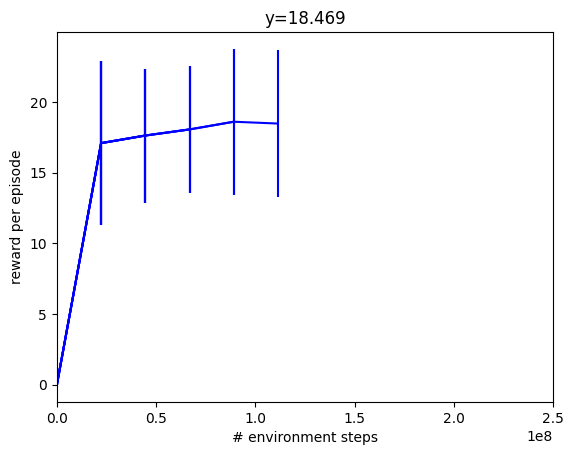

In [ ]:
make_inference_fn, params, metrics = train_fn(
    environment=env,
    eval_env=registry.load(env_name, config=env_cfg),
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

Let's rollout and render the resulting policy!

In [ ]:
# Enable perturbation in the eval env.
env_cfg = registry.get_default_config(env_name)
env_cfg.pert_config.enable = True
env_cfg.pert_config.velocity_kick = [3.0, 6.0]
env_cfg.pert_config.kick_wait_times = [5.0, 15.0]
env_cfg.command_config.a = [1.5, 0.8, 2*jp.pi]
eval_env = registry.load(env_name, config=env_cfg)
velocity_kick_range = [0.0, 0.0]  # Disable velocity kick.
kick_duration_range = [0.05, 0.2]

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

In [ ]:
#@title Rollout and Render
from mujoco_playground._src.gait import draw_joystick_command

x_vel = 0.0  #@param {type: "number"}
y_vel = 0.0  #@param {type: "number"}
yaw_vel = 3.14  #@param {type: "number"}


def sample_pert(rng):
  rng, key1, key2 = jax.random.split(rng, 3)
  pert_mag = jax.random.uniform(
      key1, minval=velocity_kick_range[0], maxval=velocity_kick_range[1]
  )
  duration_seconds = jax.random.uniform(
      key2, minval=kick_duration_range[0], maxval=kick_duration_range[1]
  )
  duration_steps = jp.round(duration_seconds / eval_env.dt).astype(jp.int32)
  state.info["pert_mag"] = pert_mag
  state.info["pert_duration"] = duration_steps
  state.info["pert_duration_seconds"] = duration_seconds
  return rng


rng = jax.random.PRNGKey(0)
rollout = []
modify_scene_fns = []

swing_peak = []
rewards = []
linvel = []
angvel = []
track = []
foot_vel = []
rews = []
contact = []
command = jp.array([x_vel, y_vel, yaw_vel])

state = jit_reset(rng)
if state.info["steps_since_last_pert"] < state.info["steps_until_next_pert"]:
  rng = sample_pert(rng)
state.info["command"] = command
for i in range(env_cfg.episode_length):
  if state.info["steps_since_last_pert"] < state.info["steps_until_next_pert"]:
    rng = sample_pert(rng)
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  state.info["command"] = command
  rews.append(
      {k: v for k, v in state.metrics.items() if k.startswith("reward/")}
  )
  rollout.append(state)
  swing_peak.append(state.info["swing_peak"])
  rewards.append(
      {k[7:]: v for k, v in state.metrics.items() if k.startswith("reward/")}
  )
  linvel.append(env.get_global_linvel(state.data))
  angvel.append(env.get_gyro(state.data))
  track.append(
      env._reward_tracking_lin_vel(
          state.info["command"], env.get_local_linvel(state.data)
      )
  )

  feet_vel = state.data.sensordata[env._foot_linvel_sensor_adr]
  vel_xy = feet_vel[..., :2]
  vel_norm = jp.sqrt(jp.linalg.norm(vel_xy, axis=-1))
  foot_vel.append(vel_norm)

  contact.append(state.info["last_contact"])

  xyz = np.array(state.data.xpos[env._torso_body_id])
  xyz += np.array([0, 0, 0.2])
  x_axis = state.data.xmat[env._torso_body_id, 0]
  yaw = -np.arctan2(x_axis[1], x_axis[0])
  modify_scene_fns.append(
      functools.partial(
          draw_joystick_command,
          cmd=state.info["command"],
          xyz=xyz,
          theta=yaw,
          scl=abs(state.info["command"][0])
          / env_cfg.command_config.a[0],
      )
  )


render_every = 2
fps = 1.0 / eval_env.dt / render_every
traj = rollout[::render_every]
mod_fns = modify_scene_fns[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = True

frames = eval_env.render(
    traj,
    camera="track",
    scene_option=scene_option,
    width=640,
    height=480,
    modify_scene_fns=mod_fns,
)
media.show_video(frames, fps=fps, loop=False)

Let's visualize the feet positions and the positional drift compared to the commanded linear and angular velocity. This is useful for debugging how well the policy follows the commands!

In [ ]:
#@title Plot each foot in a 2x2 grid.

swing_peak = jp.array(swing_peak)
names = ["FR", "FL", "RR", "RL"]
colors = ["r", "g", "b", "y"]
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(axs.flat):
  ax.plot(swing_peak[:, i], color=colors[i])
  ax.set_ylim([0, env_cfg.reward_config.max_foot_height * 1.25])
  ax.axhline(env_cfg.reward_config.max_foot_height, color="k", linestyle="--")
  ax.set_title(names[i])
  ax.set_xlabel("time")
  ax.set_ylabel("height")
plt.tight_layout()
plt.show()

linvel_x = jp.array(linvel)[:, 0]
linvel_y = jp.array(linvel)[:, 1]
angvel_yaw = jp.array(angvel)[:, 2]

# Plot whether velocity is within the command range.
linvel_x = jp.convolve(linvel_x, jp.ones(10) / 10, mode="same")
linvel_y = jp.convolve(linvel_y, jp.ones(10) / 10, mode="same")
angvel_yaw = jp.convolve(angvel_yaw, jp.ones(10) / 10, mode="same")

fig, axes = plt.subplots(3, 1, figsize=(10, 10))
axes[0].plot(linvel_x)
axes[1].plot(linvel_y)
axes[2].plot(angvel_yaw)

axes[0].set_ylim(
    -env_cfg.command_config.a[0], env_cfg.command_config.a[0]
)
axes[1].set_ylim(
    -env_cfg.command_config.a[1], env_cfg.command_config.a[1]
)
axes[2].set_ylim(
    -env_cfg.command_config.a[2], env_cfg.command_config.a[2]
)

for i, ax in enumerate(axes):
  ax.axhline(state.info["command"][i], color="red", linestyle="--")

labels = ["dx", "dy", "dyaw"]
for i, ax in enumerate(axes):
  ax.set_ylabel(labels[i])

Now let's visualize what it looks like to slowly increase linear velocity commands.

In [ ]:
#@title Slowly increase linvel commands

rng = jax.random.PRNGKey(0)
rollout = []
modify_scene_fns = []
swing_peak = []
linvel = []
angvel = []

x = -0.25
command = jp.array([x, 0, 0])
state = jit_reset(rng)
for i in range(1_400):
  # Increase the forward velocity by 0.25 m/s every 200 steps.
  if i % 200 == 0:
    x += 0.25
    print(f"Setting x to {x}")
    command = jp.array([x, 0, 0])
  state.info["command"] = command
  if state.info["steps_since_last_pert"] < state.info["steps_until_next_pert"]:
    rng = sample_pert(rng)
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state)
  swing_peak.append(state.info["swing_peak"])
  linvel.append(env.get_global_linvel(state.data))
  angvel.append(env.get_gyro(state.data))
  xyz = np.array(state.data.xpos[env._torso_body_id])
  xyz += np.array([0, 0, 0.2])
  x_axis = state.data.xmat[env._torso_body_id, 0]
  yaw = -np.arctan2(x_axis[1], x_axis[0])
  modify_scene_fns.append(
      functools.partial(
          draw_joystick_command,
          cmd=command,
          xyz=xyz,
          theta=yaw,
          scl=abs(command[0]) / env_cfg.command_config.a[0],
      )
  )


# Plot each foot in a 2x2 grid.
swing_peak = jp.array(swing_peak)
names = ["FR", "FL", "RR", "RL"]
colors = ["r", "g", "b", "y"]
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(axs.flat):
  ax.plot(swing_peak[:, i], color=colors[i])
  ax.set_ylim([0, env_cfg.reward_config.max_foot_height * 1.25])
  ax.axhline(env_cfg.reward_config.max_foot_height, color="k", linestyle="--")
  ax.set_title(names[i])
  ax.set_xlabel("time")
  ax.set_ylabel("height")
plt.tight_layout()
plt.show()

linvel_x = jp.array(linvel)[:, 0]
linvel_y = jp.array(linvel)[:, 1]
angvel_yaw = jp.array(angvel)[:, 2]

# Plot whether velocity is within the command range.
linvel_x = jp.convolve(linvel_x, jp.ones(10) / 10, mode="same")
linvel_y = jp.convolve(linvel_y, jp.ones(10) / 10, mode="same")
angvel_yaw = jp.convolve(angvel_yaw, jp.ones(10) / 10, mode="same")

fig, axes = plt.subplots(3, 1, figsize=(10, 10))
axes[0].plot(linvel_x)
axes[1].plot(linvel_y)
axes[2].plot(angvel_yaw)

axes[0].set_ylim(
    -env_cfg.command_config.a[0], env_cfg.command_config.a[0]
)
axes[1].set_ylim(
    -env_cfg.command_config.a[1], env_cfg.command_config.a[1]
)
axes[2].set_ylim(
    -env_cfg.command_config.a[2], env_cfg.command_config.a[2]
)

for i, ax in enumerate(axes):
  ax.axhline(state.info["command"][i], color="red", linestyle="--")

labels = ["dx", "dy", "dyaw"]
for i, ax in enumerate(axes):
  ax.set_ylabel(labels[i])


render_every = 2
fps = 1.0 / eval_env.dt / render_every
print(f"fps: {fps}")

traj = rollout[::render_every]
mod_fns = modify_scene_fns[::render_every]
assert len(traj) == len(mod_fns)

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = True

frames = eval_env.render(
    traj,
    camera="track",
    height=480,
    width=640,
    modify_scene_fns=mod_fns,
    scene_option=scene_option,
)
media.show_video(frames, fps=fps, loop=False)

## Handstand

Additional policies are available for the Unitree Go1 such as fall-recovery, handstand, and footstand policies. We'll use the handstand policy as an opportunity to demonstrate finetuning policies from prior checkpoints. This will allow us to quickly iterate on training curriculums by modifying the enviornment config between runs.

For the Go1 handstand policy, we'll first train with the default configuration, and then add an energy penalty to make the policy smoother and more likely to transfer onto the robot.

In [ ]:
from mujoco_playground.config import locomotion_params

env_name = 'Go1Handstand'
env = registry.load(env_name)
env_cfg = registry.get_default_config(env_name)
ppo_params = locomotion_params.brax_ppo_config(env_name)

Let's create a checkpoint directory and then train a policy with checkpointing.

In [ ]:
ckpt_path = epath.Path("checkpoints").resolve() / env_name
ckpt_path.mkdir(parents=True, exist_ok=True)
print(f"{ckpt_path}")

with open(ckpt_path / "config.json", "w") as fp:
  json.dump(env_cfg.to_dict(), fp, indent=4)

In [ ]:
#@title Training fn definition
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def policy_params_fn(current_step, make_policy, params):
  del make_policy  # Unused.
  orbax_checkpointer = ocp.PyTreeCheckpointer()
  save_args = orbax_utils.save_args_from_target(params)
  path = ckpt_path / f"{current_step}"
  orbax_checkpointer.save(path, params, force=True, save_args=save_args)


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

randomizer = registry.get_domain_randomizer(env_name)
ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    randomization_fn=randomizer,
    progress_fn=progress,
    policy_params_fn=policy_params_fn,
)

The initial policy takes 8 minutes to train on an RTX 4090.

In [ ]:
make_inference_fn, params, metrics = train_fn(
    environment=registry.load(env_name, config=env_cfg),
    eval_env=registry.load(env_name, config=env_cfg),
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

Let's visualize the current policy.

In [ ]:
#@title Rollout and Render
inference_fn = make_inference_fn(params, deterministic=True)
jit_inference_fn = jax.jit(inference_fn)

eval_env = registry.load(env_name, config=env_cfg)
jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

rng = jax.random.PRNGKey(12345)
rollout = []
rewards = []
torso_height = []
actions = []
torques = []
power = []
qfrc_constraint = []
qvels = []
power1 = []
power2 = []
for _ in range(10):
  rng, reset_rng = jax.random.split(rng)
  state = jit_reset(reset_rng)
  for i in range(env_cfg.episode_length // 2):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    actions.append(ctrl)
    state = jit_step(state, ctrl)
    rollout.append(state)
    rewards.append(
        {k[7:]: v for k, v in state.metrics.items() if k.startswith("reward/")}
    )
    torso_height.append(state.data.qpos[2])
    torques.append(state.data.actuator_force)
    qvel = state.data.qvel[6:]
    power.append(jp.sum(jp.abs(qvel * state.data.actuator_force)))
    qfrc_constraint.append(jp.linalg.norm(state.data.qfrc_constraint[6:]))
    qvels.append(jp.max(jp.abs(qvel)))
    frc = state.data.actuator_force
    qvel = state.data.qvel[6:]
    power1.append(jp.sum(frc * qvel))
    power2.append(jp.sum(jp.abs(frc * qvel)))


render_every = 2
fps = 1.0 / eval_env.dt / render_every
traj = rollout[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False

frames = eval_env.render(
    traj, camera="side", scene_option=scene_option, height=480, width=640
)
media.show_video(frames, fps=fps, loop=False)

power = jp.array(power1)
print(f"Max power: {jp.max(power)}")

Notice that the above policy looks jittery and unlikely to transfer on the robot. The max power output is also quite high.

The sim-to-real deployment of the handstand policy was trained using a curriculum on the `energy_termination_threshold`, `energy` and `dof_acc`, which are config values that penalize high torques and high power output. Let's finetune the above policy with a decreased  `energy_termination_threshold`, as well as non-zero values for `energy` and `dof_acc` rewards to get a smoother policy.

### Finetune the previous checkpoint

In [ ]:
env_cfg = registry.get_default_config(env_name)
env_cfg.energy_termination_threshold = 400  # lower energy termination threshold
env_cfg.reward_config.energy = -0.003  # non-zero negative `energy` reward
env_cfg.reward_config.dof_acc = -2.5e-7  # non-zero negative `dof_acc` reward

FINETUNE_PATH = epath.Path(ckpt_path)
latest_ckpts = list(FINETUNE_PATH.glob("*"))
latest_ckpts = [ckpt for ckpt in latest_ckpts if ckpt.is_dir()]
latest_ckpts.sort(key=lambda x: int(x.name))
latest_ckpt = latest_ckpts[-1]
restore_checkpoint_path = latest_ckpt

In [ ]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]

make_inference_fn, params, metrics = train_fn(
    environment=registry.load(env_name, config=env_cfg),
    eval_env=registry.load(env_name, config=env_cfg),
    wrap_env_fn=wrapper.wrap_for_brax_training,
    restore_checkpoint_path=restore_checkpoint_path,  # restore from the checkpoint!
    seed=1,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [ ]:
#@title Rollout and Render Finetune Policy
inference_fn = make_inference_fn(params, deterministic=True)
jit_inference_fn = jax.jit(inference_fn)

eval_env = registry.load(env_name, config=env_cfg)
jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

rng = jax.random.PRNGKey(12345)
rollout = []
rewards = []
torso_height = []
actions = []
torques = []
power = []
qfrc_constraint = []
qvels = []
power1 = []
power2 = []
for _ in range(10):
  rng, reset_rng = jax.random.split(rng)
  state = jit_reset(reset_rng)
  for i in range(env_cfg.episode_length // 2):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    actions.append(ctrl)
    state = jit_step(state, ctrl)
    rollout.append(state)
    rewards.append(
        {k[7:]: v for k, v in state.metrics.items() if k.startswith("reward/")}
    )
    torso_height.append(state.data.qpos[2])
    torques.append(state.data.actuator_force)
    qvel = state.data.qvel[6:]
    power.append(jp.sum(jp.abs(qvel * state.data.actuator_force)))
    qfrc_constraint.append(jp.linalg.norm(state.data.qfrc_constraint[6:]))
    qvels.append(jp.max(jp.abs(qvel)))
    frc = state.data.actuator_force
    qvel = state.data.qvel[6:]
    power1.append(jp.sum(frc * qvel))
    power2.append(jp.sum(jp.abs(frc * qvel)))


render_every = 2
fps = 1.0 / eval_env.dt / render_every
traj = rollout[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False

frames = eval_env.render(
    traj, camera="side", scene_option=scene_option, height=480, width=640
)
media.show_video(frames, fps=fps, loop=False)

power = jp.array(power1)
print(f"Max power: {jp.max(power)}")

The final policy should exhibit smoother behavior and have less power output! Feel free to finetune the policy some more using different reward terms to get the best behavior.

# Bipedal

MuJoCo Playground also comes with a host of bipedal environments, such as the Berkely Humanoid and the Unitree G1/H1. Let's demonstrate a joystick policy on the Berkeley Humanoid. The initial policy takes 17 minutes to train on an RTX 4090.

In [ ]:
env_name = 'BerkeleyHumanoidJoystickFlatTerrain'
env = registry.load(env_name)
env_cfg = registry.get_default_config(env_name)
ppo_params = locomotion_params.brax_ppo_config(env_name)

In [ ]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]

randomizer = registry.get_domain_randomizer(env_name)
ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    randomization_fn=randomizer,
    progress_fn=progress
)

In [ ]:
make_inference_fn, params, metrics = train_fn(
    environment=env,
    eval_env=registry.load(env_name, config=env_cfg),
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [ ]:
#@title Rollout and Render
from mujoco_playground._src.gait import draw_joystick_command

env = registry.load(env_name)
eval_env = registry.load(env_name)
jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

rng = jax.random.PRNGKey(1)

rollout = []
modify_scene_fns = []

x_vel = 1.0  #@param {type: "number"}
y_vel = 0.0  #@param {type: "number"}
yaw_vel = 0.0  #@param {type: "number"}
command = jp.array([x_vel, y_vel, yaw_vel])

phase_dt = 2 * jp.pi * eval_env.dt * 1.5
phase = jp.array([0, jp.pi])

for j in range(1):
  print(f"episode {j}")
  state = jit_reset(rng)
  state.info["phase_dt"] = phase_dt
  state.info["phase"] = phase
  for i in range(env_cfg.episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    if state.done:
      break
    state.info["command"] = command
    rollout.append(state)

    xyz = np.array(state.data.xpos[eval_env.mj_model.body("torso").id])
    xyz += np.array([0, 0.0, 0])
    x_axis = state.data.xmat[eval_env._torso_body_id, 0]
    yaw = -np.arctan2(x_axis[1], x_axis[0])
    modify_scene_fns.append(
        functools.partial(
            draw_joystick_command,
            cmd=state.info["command"],
            xyz=xyz,
            theta=yaw,
            scl=np.linalg.norm(state.info["command"]),
        )
    )

render_every = 1
fps = 1.0 / eval_env.dt / render_every
print(f"fps: {fps}")
traj = rollout[::render_every]
mod_fns = modify_scene_fns[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = False

frames = eval_env.render(
    traj,
    camera="track",
    scene_option=scene_option,
    width=640*2,
    height=480,
    modify_scene_fns=mod_fns,
)
media.show_video(frames, fps=fps, loop=False)

🙌 Hasta la vista!